<hr>

<font color=skyblue>**去除模糊影像的 CNN 深度學習實驗（Image Deblurring using Convolutional Neural Networks and Deep Learning）**</font>

Reference: 

教學網站：https://debuggercafe.com/image-deblurring-using-convolutional-neural-networks-and-deep-learning/

參考論文：https://www.researchgate.net/publication/328985265_Image_Deblurring_and_Super-Resolution_Using_Deep_Convolutional_Neural_Networks#fullTextFileContent
<hr>

<font color=skyblue>Loading necessary packages</font>
<hr>

In [ ]:
import cv2
import os
import time
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
# below is for the custom defs
from Deblurring_defs import  (
    DeblurDataset, DeblurCNN, DeblurCNN_RES, DeblurSuperResCNN, 
    save_decoded_image, psnr
)

<font color=skyblue>Set up global constants and variables</font>


In [ ]:
DIR_PATH = '../'
IMG_RESIZE = (224, 224) # 注意：將訓練影像大小改為 224x224
# IMG_RESIZE = (33, 33) # 注意：依據訓練資料大小不同，將訓練影像大小改為 33x33
BATCH_SIZE = 2
LEARNING_RATE = 0.001 # Learning rate.
NUM_EPOCHS = 10 # Number of epochs to train the model
WEIGHTS = DIR_PATH + 'outputs/pre_trained_model.pt' # Path to the pre-trained model

# blur_path = DIR_PATH + 'inputs/T91_blurred_patches' # Directory containing the blurred images
# sharp_path = DIR_PATH + 'inputs/T91_sharp_patches' # Directory containing the sharp images

blur_path = DIR_PATH + 'inputs/gaussian_blurred' # Directory containing the blurred images
sharp_path = DIR_PATH + 'inputs/General100' # Directory containing the sharp images
# Create the directory to save the images if it doesn't exist
image_dir = DIR_PATH + 'outputs/saved_images' # Directory to save validation images during training
os.makedirs(image_dir, exist_ok=True)


<hr>
<font color=skyblue>Setup the CNN model.</font>
<hr>

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print('Using {} device'.format(device))

# model = DeblurCNN().to(device)
model = DeblurCNN_RES().to(device)
# model = DeblurSuperResCNN().to(device)

print(f"Model: {model}")

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

lr = LEARNING_RATE # Learning rate.
optimizer = optim.Adam(model.parameters(), lr=lr)
print(f"Learning rate: {lr}")
print(f"Optimizer: {optimizer}")
# Loss function.
criterion = nn.MSELoss()
print(f"Loss function: {criterion}")

# scheduler is to reduce the learning rate when a monitored metric (like validation loss) stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        # verbose=True
    )

Using cpu device
Model: DeblurCNN_RES(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)
20,099 total parameters.
20,099 training parameters.
Learning rate: 0.001
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Loss function: MSELoss()


<hr>
<font color=skyblue>Reloading the pre-trained model if any</font>
<hr>

In [4]:
# resume training if weights are present.
if os.path.exists(WEIGHTS):
    print('Weights file found. Resuming training...')

    checkpoint = torch.load(WEIGHTS)
    print("Resuming the model state...")
    model.load_state_dict(checkpoint['model_state_dict'])
    pre_trained_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch: {pre_trained_epoch}")
    # Load the optimizer state if available. may not be good idea to resume.
    print("Resuming the optimizer state...")
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    pre_trained_epoch = 0
    print('No pre-trained file found. Starting training from scratch...')
print(f"Current Model: {model}")


Weights file found. Resuming training...
Resuming the model state...
Resuming training from epoch: 10
Resuming the optimizer state...
Current Model: DeblurCNN_RES(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


<hr>
<font color=skyblue>Prepare training and validating data</font>
<hr>

In [9]:
gauss_blur = os.listdir(blur_path)
gauss_blur.sort()
sharp = os.listdir(sharp_path)
sharp.sort()
x_blur = [] # images names for gauss blurred images
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])
y_sharp = [] # images names for sharp images
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.1)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")

# define transforms to resize and convert images to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_RESIZE), # Resize images to IMG_RESIZE for training
    transforms.ToTensor(),
])

train_data = DeblurDataset(blur_path, x_train, sharp_path, y_train, transform)
val_data = DeblurDataset(blur_path, x_val, sharp_path, y_val, transform)
 
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=1, shuffle=False)

Train data instances: 90
Validation data instances: 10


<hr>
<font color=skyblue>Define training process</font>
<hr>

In [6]:
def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
        running_psnr +=  psnr(sharp_image, outputs)
    
    train_loss = running_loss/len(dataloader.dataset)
    train_psnr = running_psnr/len(dataloader)
    print(f"Train Loss: {train_loss:.5f} - Train PSNR: {train_psnr:.2f} dB")
    # print(f"Train Loss: {train_loss:.5f}")
    
    return train_loss, train_psnr

<hr>
<font color=skyblue>Define validating process</font>

Disable the "save_decode_image" function to avoid saving the decoded images during validation. This will speed up the validation process.
<hr>

In [7]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            running_psnr +=  psnr(sharp_image, outputs)
            # ---- This part should be removed for large epochs ----
            if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-2):
                save_decoded_image(sharp_image.cpu().data, name = f"{image_dir}/sharp{epoch}.jpg", size=IMG_RESIZE)
                save_decoded_image(blur_image.cpu().data, name = f"{image_dir}/blur{epoch}.jpg", size=IMG_RESIZE)
                save_decoded_image(outputs.cpu().data, name = f"{image_dir}/deblurred{epoch}.jpg", size=IMG_RESIZE)
            if i == int((len(val_data)/dataloader.batch_size)-2): 
                save_decoded_image(outputs.cpu().data, name = f"{image_dir}/val_deblurred{epoch}.jpg", size=IMG_RESIZE)
            # ------------------------------------------------------
            
        val_loss = running_loss/len(dataloader.dataset)
        val_psnr = running_psnr/len(dataloader)
        print(f"Val Loss: {val_loss:.5f} - Val PSNR: {val_psnr:.2f} dB")
        
        return val_loss, val_psnr

<hr>
<font color=skyblue>Start training</font>
<hr>

In [8]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start_time = time.time()
epochs = NUM_EPOCHS
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_epoch_loss, train_epoch_psnr = fit(model, trainloader, epoch)
    val_epoch_loss, val_epoch_psnr = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    scheduler.step(val_epoch_loss)

end_time = time.time()
print(f"Took {((end_time-start_time)/60):.3f} minutes to train")
print('Saving model...')
# save the model
cumulative_epochs = epochs + pre_trained_epoch

torch.save({
    'epoch': cumulative_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, WEIGHTS)
print(f"Model saved as {WEIGHTS}")


Epoch 1 of 10


100%|██████████| 45/45 [00:05<00:00,  8.42it/s]


Train Loss: 0.00251 - Train PSNR: 23.62 dB


100%|██████████| 10/10 [00:00<00:00, 21.83it/s]


Val Loss: 0.00438 - Val PSNR: 24.58 dB
Epoch 2 of 10


100%|██████████| 45/45 [00:04<00:00, 10.94it/s]


Train Loss: 0.00246 - Train PSNR: 23.87 dB


100%|██████████| 10/10 [00:00<00:00, 33.41it/s]


Val Loss: 0.00417 - Val PSNR: 24.86 dB
Epoch 3 of 10


100%|██████████| 45/45 [00:04<00:00, 10.75it/s]


Train Loss: 0.00245 - Train PSNR: 23.74 dB


100%|██████████| 10/10 [00:00<00:00, 31.56it/s]


Val Loss: 0.00419 - Val PSNR: 24.81 dB
Epoch 4 of 10


100%|██████████| 45/45 [00:04<00:00, 10.58it/s]


Train Loss: 0.00245 - Train PSNR: 23.71 dB


100%|██████████| 10/10 [00:00<00:00, 32.46it/s]


Val Loss: 0.00428 - Val PSNR: 24.67 dB
Epoch 5 of 10


100%|██████████| 45/45 [00:04<00:00, 10.41it/s]


Train Loss: 0.00242 - Train PSNR: 23.92 dB


100%|██████████| 10/10 [00:00<00:00, 30.13it/s]


Val Loss: 0.00448 - Val PSNR: 24.44 dB
Epoch 6 of 10


100%|██████████| 45/45 [00:04<00:00,  9.84it/s]


Train Loss: 0.00250 - Train PSNR: 23.65 dB


100%|██████████| 10/10 [00:00<00:00, 30.98it/s]


Val Loss: 0.00452 - Val PSNR: 24.39 dB
Epoch 7 of 10


100%|██████████| 45/45 [00:04<00:00,  9.55it/s]


Train Loss: 0.00243 - Train PSNR: 23.73 dB


100%|██████████| 10/10 [00:00<00:00, 28.97it/s]


Val Loss: 0.00429 - Val PSNR: 24.68 dB
Epoch 8 of 10


100%|██████████| 45/45 [00:04<00:00,  9.57it/s]


Train Loss: 0.00242 - Train PSNR: 23.84 dB


100%|██████████| 10/10 [00:00<00:00, 27.84it/s]


Val Loss: 0.00423 - Val PSNR: 24.71 dB
Epoch 9 of 10


100%|██████████| 45/45 [00:04<00:00,  9.52it/s]


Train Loss: 0.00239 - Train PSNR: 24.00 dB


100%|██████████| 10/10 [00:00<00:00, 28.13it/s]


Val Loss: 0.00404 - Val PSNR: 24.98 dB
Epoch 10 of 10


100%|██████████| 45/45 [00:05<00:00,  8.06it/s]


Train Loss: 0.00237 - Train PSNR: 23.92 dB


100%|██████████| 10/10 [00:00<00:00, 22.33it/s]

Val Loss: 0.00430 - Val PSNR: 24.66 dB
Took 0.835 minutes to train
Saving model...
Model saved as ../outputs/pre_trained_model.pt


<font color=skyblue>Display the Loss and PSNR values over the epochs</font>

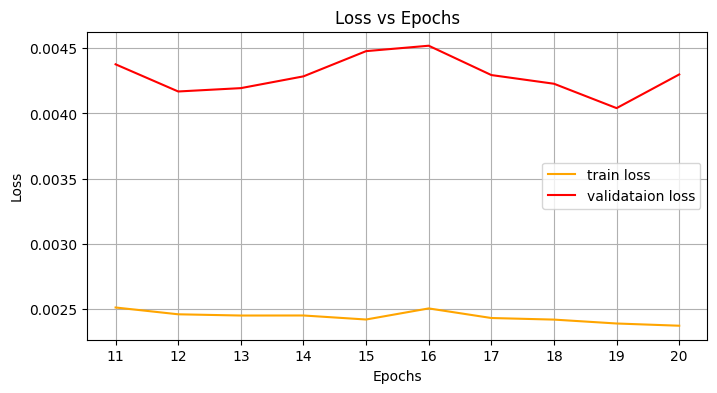

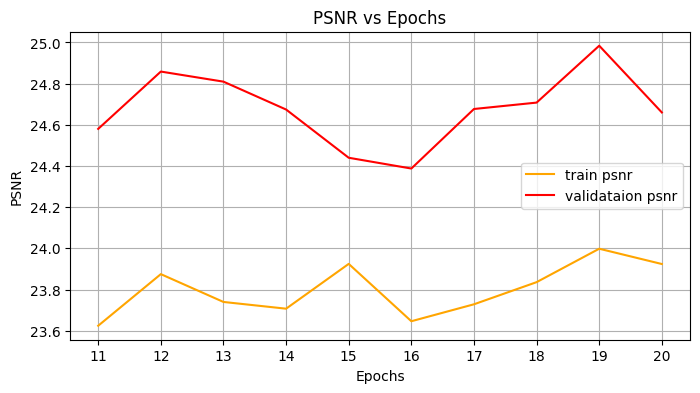

In [11]:
# loss plots
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')

num_points = len(train_loss)
num_ticks = 10 if num_points >= 10 else num_points
tick_positions = np.linspace(0, num_points-1, num_ticks, dtype=int)
tick_labels = [pre_trained_epoch + i + 1 for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels)

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig(DIR_PATH + 'outputs/loss.png')
plt.show()
# save the model to disk
plt.figure(figsize=(8, 4))
plt.plot(train_psnr, color='orange', label='train psnr')
plt.plot(val_psnr, color='red', label='validataion psnr')
plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.title('PSNR vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.grid()
plt.savefig(DIR_PATH + 'outputs/psnr.png')
plt.show()


<font color=skyblue>Show and save images in Validate set</font>

呈現並儲存前五張 validate data 的影像。

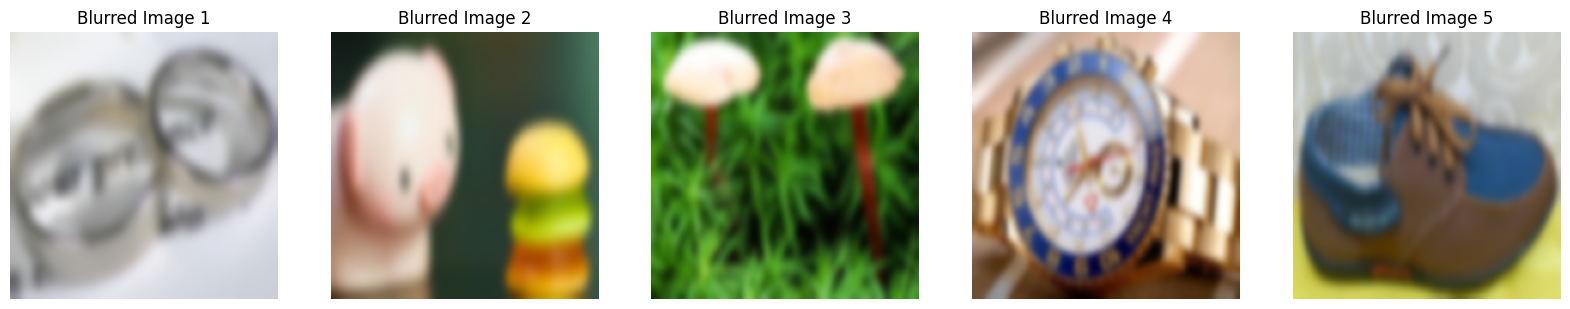

In [11]:
# plot the first 5 images of the validation set
import matplotlib.pyplot as plt

def plot_images(images, titles=None):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for i, ax in enumerate(axes):
        if titles is not None:
            ax.set_title(titles[i])
        ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax.axis('off')
    plt.show()

# plot the first 5 images of the validation set
images = []
titles = []

for i in range(5):
    images.append(val_data[i][0])
    titles.append(f"Blurred Image {i+1}")
    # save the blurred image
    save_decoded_image(val_data[i][0].unsqueeze(0), name=image_dir+f"/val{i}.jpg", size=IMG_RESIZE)
plot_images(images, titles)
# plot the first 5 images of the validation set


<font color=skyblue>產品展示</font>

- 輸入任意圖像
- 先進行高斯模糊化
- 轉換模糊圖像矩陣為 tensor 矩陣
- 再送入已訓練好之 CNN 模型得到去除模糊圖像
- 轉換去除模糊圖像為 numpy 矩陣
- 最後呈現模型的表現。

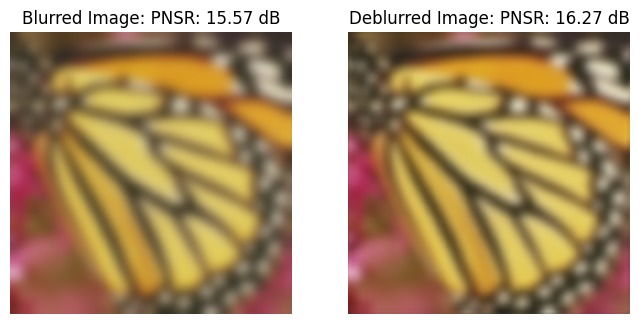

In [12]:
# load an image from pictures directory
sharp = cv2.imread('../inputs/Set5/butterfly.PNG', cv2.IMREAD_COLOR)
sharp = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)
sharp_tensor = transforms.ToPILImage()(sharp)
sharp_tensor = transforms.ToTensor()(sharp_tensor)
sharp_tensor = sharp_tensor.unsqueeze(0) # add batch dimension
# add gaussian blurring
blur = cv2.GaussianBlur(sharp, (31, 31), 0)
# convert the blur to tensor without resizing
blur_tensor = transforms.ToPILImage()(blur)
blur_tensor = transforms.ToTensor()(blur_tensor)
blur_tensor = blur_tensor.unsqueeze(0) # add batch dimension
blur_tensor = blur_tensor.to(device)

# deblur the image
with torch.no_grad():
    deblurred_tensor = model(blur_tensor)

psnr_blur = psnr(sharp_tensor, blur_tensor)
psnr_deblur = psnr(sharp_tensor, deblurred_tensor)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
img0 = blur_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
img1 = deblurred_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

# Clip to [0, 1] if float, or [0, 255] if uint8
img0 = np.clip(img0, 0, 1)
img1 = np.clip(img1, 0, 1)

ax[0].imshow(img0)
ax[0].set_title('Blurred Image: PNSR: {:.2f} dB'.format(psnr_blur))
ax[0].axis('off')
ax[1].imshow(img1)
ax[1].set_title('Deblurred Image: PNSR: {:.2f} dB'.format(psnr_deblur))
ax[1].axis('off')
plt.show()


<hr>
<font color=skyblue>Download the dataset from Kaggle: 1.47G</font>

- sharp images : 350 images
- motion blurring images : 350 images
- defocus blurring images : 350 images


In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("kwentar/blur-dataset")

# print("Path to dataset files:", path)